<a href="https://colab.research.google.com/github/bitterns/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [ ]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

## 14-2 수집 데이터 확인

In [3]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [ ]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [ ]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

# 1

In [26]:
set_seed(86) # ! 42 설정 시 의도와 다른 결과 발생
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

# 2

2


In [7]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [8]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It features a person wearing a denim jacket and pants, which are common items of casual wear. The style of the clothing suggests a relaxed, possibly streetwear-inspired aesthetic. The focus on the attire indicates that it may be used for fashion-related purposes, such as showcasing a particular brand or style.
Yes.
Yes, this image appears to be a fashion-related photograph. The individuals are dressed in coordinated outfits that suggest they may be models showcasing clothing items for a catalog or a brand's lookbook. The setting is minimalistic and designed to highlight the garments rather than distract with extraneous details. The lighting and composition of the photo are typical of professional fashion photography, which aims to present the clothes in an appealing way while allowing viewers to focus on the style and fit of the apparel.
Yes, this image is of clothing. Specifically, it features a pair of shoes which are a type of footwear. The question a

## 14-6 의류 판단 결과 시각화

In [9]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,False
5,,False
6,,True
7,,True
8,,False
9,,True


## 14-7 의류 이미지 필터링

In [10]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [11]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
6,,True
7,,True
9,,True
10,,True


## 14-8 의류 스타일 분석

In [12]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [13]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image reflects a casual and relaxed fashion sense, often associated with contemporary streetwear. The use of denim is a classic choice that has seen resurgence in popularity over the years, particularly within urban fashion circles. Denim's enduring appeal lies in its versatility and durability, making it a staple for everyday wear.\n\nThe light blue denim jacket is likely made from a heavy-duty fabric like selvedge or indigo, which are favored for their quality and aesthetic value. This type of denim is often associated with a vintage or retro look, which has been a recurring trend in men's fashion. The jacket's slightly worn appearance suggests an intentional distressed look, a common feature in modern streetwear that adds character and a lived-in feel to the garment.\n\nThe beige T-shirt underneath provides a neutral base that complements the denim without overpowering it. Neutral colors like beige are timeless and can be easily paired with various other colors, making them a practical choice for layering. The rolled-up sleeves on both the jacket and the shirt add to the laid-back vibe, indicating a preference for comfort and ease of movement.\n\nOverall, the outfit combines elements of casual chic, with an emphasis on comfort and a touch of ruggedness. It aligns with trends that favor simplicity, functionality, and a nod to classic styles with a modern twist."
1,,True,"The style of the clothes worn by the individual in the image leans towards a military-inspired or utilitarian fashion trend. This type of clothing often features practical elements such as multiple pockets, adjustable cuffs, and durable materials that suggest functionality and durability over aesthetic appeal. The muted olive green color is characteristic of military uniforms and has been widely adopted in contemporary casual wear for its versatility and timeless look.\n\nThe trend changes within this category have seen a shift from purely functional attire to more fashionable interpretations. Modern iterations include subtle color variations, modern cuts, and sometimes even incorporating soft fabrics like cotton or linen, which add comfort without compromising on utility. Accessories like the brown bag attached to the jacket also hint at a blend of utility with personal style, suggesting that these pieces are designed not just for work but also for everyday use where personal expression can be incorporated through accessories.\n\nIn summary, the clothing style reflects a blend of historical military influence with modern fashion sensibilities, emphasizing both practicality and understated elegance."
2,,True,"The style of the clothes worn by both individuals in the image leans towards a minimalist and relaxed aesthetic, which is often associated with contemporary casual fashion. The use of neutral colors such as beige, grey, and maroon suggests a preference for understated elegance over bold statements.\n\nThe cardigan on the left person adds a layer that could be indicative of transitional weather, where layers are essential but not too heavy, pointing to spring or fall trends. Cardigans themselves have been a staple in men's fashion for decades, often associated with a preppy or classic look when paired with tailored trousers. Here, however, they're used in a more casual context, suggesting a modern twist on traditional styles.\n\nThe shorts on both individuals are cut in a way that suggests comfort and ease of movement, which is a common trend in streetwear and casual wear. The length and fit of the shorts are consistent with what might be seen in summer collections, indicating these outfits were likely designed for warm weather.\n\nOverall, the clothing reflects a blend of classic pieces updated for a modern, laid-back lifestyle. This combination of timeless garments reimagined in simple, versatile color palettes aligns with current fashion trends that favor simplicity, comfort, and versat

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [ ]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct',
          tensor_parallel_size=1,
          dtype="half",
          gpu_memory_utilization=0.5,
          max_model_len=10000,
          trust_remote_code=True # ValidationError)
)

## 14-10 색상 정보 추출

In [15]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-21 16:12:47 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, est. speed input: 420.64 toks/s, output: 30.75 toks/s]


- **파란색** (light blue denim jacket)
- **베이지** (beige T-shirt)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, est. speed input: 844.96 toks/s, output: 29.02 toks/s]


**색상:**
- 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, est. speed input: 935.46 toks/s, output: 29.89 toks/s]


- beige
- grey
- maroon


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, est. speed input: 881.44 toks/s, output: 25.30 toks/s]


색상: 갈색, 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, est. speed input: 558.74 toks/s, output: 33.56 toks/s]


- 민트 그린 (Mint Green)
- 라이트 블루 (Light Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, est. speed input: 786.96 toks/s, output: 31.03 toks/s]


**색상:**
- 베이지
- 카키


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, est. speed input: 880.09 toks/s, output: 29.01 toks/s]


**색상:**
- 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, est. speed input: 864.16 toks/s, output: 30.96 toks/s]

**색상:**
- 회색 (gray)


## 14-11 스타일 키워드 추출

In [16]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it, est. speed input: 344.19 toks/s, output: 38.02 toks/s]


- 캐주얼
- 편안함
- 스트리트웨어
- 데님
- 빈티지/레트로
- distressed
- 중립색 (베이지)
- 레이어드
- 실용성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 161.79 toks/s, output: 39.83 toks/s]


- 군사적 영감
- 실용성
- 다목적
- 내구성
- muted olive green
- 현대적 해석
- 부드러운 소재 (cotton, linen)
- 액세서리 활용 (갈색 가방 등)
- 역사적 군사 영향
- 현대 패션 감각
- 실용성과 세련됨


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 193.04 toks/s, output: 39.83 toks/s]


- **미니멀리즘**
- **편안함**
- **자연스러운 우아함**
- **전이 시즌**
- **전통적**
- **현대적**
- **편안한 움직임**
- **여름 트렌드**
- **단순함**
- **실용성**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 111.90 toks/s, output: 41.36 toks/s]


- **스타일**: moccasins
- **특징**: 부드러운 상부, 유연한 밑창
- **역사**: 원주민 footwear 기원
- **인기**: 전 세계적 인기 증가
- **색상**: 중성적 (갈색, 회색)
- **트렌드**: 최근 인기 부활
- **착용**: 캐주얼웨어, 고급 occasions에도 적합


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it, est. speed input: 197.84 toks/s, output: 39.57 toks/s]


- 캐주얼
- thoughtfully layered
- 현대 스트리트웨어
- 민트 그린
- 트렌디
- 신선함
- 젊음
- 편안함
- 다양성
- 클래식
- 빈티지
- 내구성
- 여유로움
- 디테일
- 약간의 테일러링


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 148.64 toks/s, output: 40.20 toks/s]


- **미니멀리즘**
- **실용주의**
- **내구성**
- **실용성**
- **실용적**
- **편안함**
- **다양성**
- **실용적 전환성**
- **텍스처**
- **깊이**
- **현대적**
- **성별 중립적**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, est. speed input: 365.11 toks/s, output: 37.17 toks/s]


- cozy
- casual
- warm
- earthy
- minimalist
- sustainable
- timeless
- functional
- comfortable


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, est. speed input: 292.59 toks/s, output: 37.88 toks/s]

- 현대적 미니멀리즘
- 모노톤 그레이
- 루즈핏 블레이저
- 단순함
- 레이어링
- 편안함
- 대조적 색상 (그레이와 화이트)


In [17]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image reflects a casual and relaxed fashion sense, often associated with contemporary streetwear. The use of denim is a classic choice that has seen resurgence in popularity over the years, particularly within urban fashion circles. Denim's enduring appeal lies in its versatility and durability, making it a staple for everyday wear.\n\nThe light blue denim jacket is likely made from a heavy-duty fabric like selvedge or indigo, which are favored for their quality and aesthetic value. This type of denim is often associated with a vintage or retro look, which has been a recurring trend in men's fashion. The jacket's slightly worn appearance suggests an intentional distressed look, a common feature in modern streetwear that adds character and a lived-in feel to the garment.\n\nThe beige T-shirt underneath provides a neutral base that complements the denim without overpowering it. Neutral colors like beige are timeless and can be easily paired with various other colors, making them a practical choice for layering. The rolled-up sleeves on both the jacket and the shirt add to the laid-back vibe, indicating a preference for comfort and ease of movement.\n\nOverall, the outfit combines elements of casual chic, with an emphasis on comfort and a touch of ruggedness. It aligns with trends that favor simplicity, functionality, and a nod to classic styles with a modern twist.",- **파란색** (light blue denim jacket)\n- **베이지** (beige T-shirt),- 캐주얼\n- 편안함\n- 스트리트웨어\n- 데님\n- 빈티지/레트로\n- distressed\n- 중립색 (베이지)\n- 레이어드\n- 실용성
1,,True,"The style of the clothes worn by the individual in the image leans towards a military-inspired or utilitarian fashion trend. This type of clothing often features practical elements such as multiple pockets, adjustable cuffs, and durable materials that suggest functionality and durability over aesthetic appeal. The muted olive green color is characteristic of military uniforms and has been widely adopted in contemporary casual wear for its versatility and timeless look.\n\nThe trend changes within this category have seen a shift from purely functional attire to more fashionable interpretations. Modern iterations include subtle color variations, modern cuts, and sometimes even incorporating soft fabrics like cotton or linen, which add comfort without compromising on utility. Accessories like the brown bag attached to the jacket also hint at a blend of utility with personal style, suggesting that these pieces are designed not just for work but also for everyday use where personal expression can be incorporated through accessories.\n\nIn summary, the clothing style reflects a blend of historical military influence with modern fashion sensibilities, emphasizing both practicality and understated elegance.",**색상:**\n- 올리브 그린,"- 군사적 영감\n- 실용성\n- 다목적\n- 내구성\n- muted olive green\n- 현대적 해석\n- 부드러운 소재 (cotton, linen)\n- 액세서리 활용 (갈색 가방 등)\n- 역사적 군사 영향\n- 현대 패션 감각\n- 실용성과 세련됨"
2,,True,"The style of the clothes worn by both individuals in the image leans towards a minimalist and relaxed aesthetic, which is often associated with contemporary casual fashion. The use of neutral colors such as beige, grey, and maroon suggests a preference for understated elegance over bold statements.\n\nThe cardigan on the left person adds a layer that could be indicative of transitional weather, where layers are essential but not too heavy, pointing to spring or fall trends. Cardigans themselves have been a staple in men's fashion for decades, often associated with a preppy or classic look when paired with tailored trousers. Here, however, they're used in a more casual context, suggesting a modern twist on traditional styles.\n\nThe shorts on both individuals are cut in a way that suggests comfort and ease of movement, which is a common trend in streetwear and casual wear. The length and fit of the shorts are consistent with what might be seen in summer collections, indi

## 14-12 텍스트 데이터 정제

In [18]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

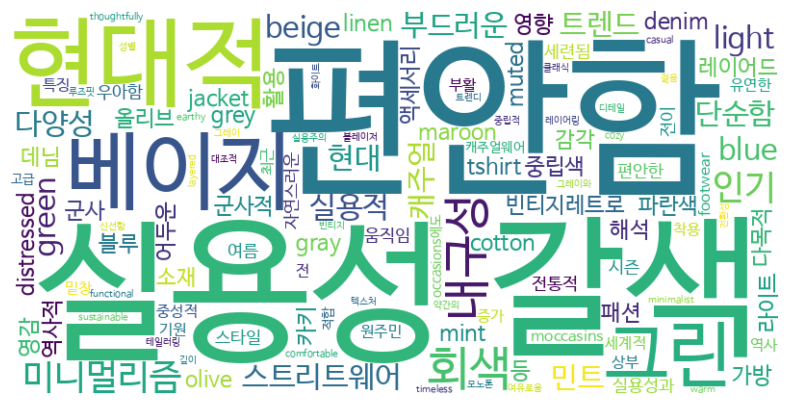

In [19]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [20]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:18<00:00, 18.08s/it, est. speed input: 137.15 toks/s, output: 38.77 toks/s]


In [21]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 다양한 패션 룩북에서 관찰되는 주요 트렌드를 종합적으로 분석하고, 이를 통해 현재 패션 산업의 방향성을 제시합니다. 주요 분석 대상은 다양한 색상 팔레트, 소재 선택, 실루엣 및 액세서리 활용 등에 초점을 맞추었습니다.

## 트렌드 분석

### 1. **미니멀리즘과 실용성의 융합**
- **색상 팔레트**: 중성적인 톤(베이지, 그레이, 올리브 그린 등)이 주를 이루며, 이는 편안함과 세련됨을 동시에 제공합니다. 특히, **마인드풀 패션**이 강조되며, 과도한 패턴이나 장식보다는 단순하고 깔끔한 디자인이 선호됩니다.
- **소재 선택**: 내구성과 편안함을 중시하는 소재들이 주를 이루고 있습니다. 예를 들어, **데님**과 **마모된 느낌의 청바지**는 일상적인 편안함과 동시에 스타일리시함을 제공합니다. **울**과 **면** 소재는 겨울 시즌에 특히 인기가 있으며, **마모된 가죽**은 고급스러움과 실용성을 결합합니다.

### 2. **기능성과 스타일의 조화**
- **실루엣**: **오버사이즈 코트**와 **롤업 팬츠**는 편안함과 동시에 세련된 이미지를 제공합니다. **마occasin 스타일의 신발**은 캐주얼하면서도 고급스러운 느낌을 주며, **실용적인 디자인의 액세서리** (예: 브라운 가방)는 일상적인 활동성과 개인적인 스타일을 결합합니다.
- **레이어링**: **다양한 레이어링 기법**이 활용되며, 이는 계절 변화에 유연하게 대응할 수 있는 능력을 제공합니다. 예를 들어, **hoodie와 denim shirt의 조합**은 편안함과 동시에 현대적인 감각을 부여합니다.

### 3. **지속 가능성과 투자 가치**
- **환경 친화적 소재**: **자연스러운 색상 팔레트**와 **내구성 있는 소재**는 지속 가능한 패션 트렌드를 반영합니다. **투자 가치가 높은** 의류는 장기적으로 착용 가능하며, 계절 변화에 따라 다양한 방식으로 활용될 수 있습니다.
- **기능성과 스타일의 균형**: **실용적인 디자인**이 강조되면서, 이러한 제품들은 일상적인 활동뿐만 아니라 다양한 사회적 상황에서도 활용 가능합니다.

## 결론
최근 패션 트렌드는 **미니멀리즘과 실용성의 융합**, **기능성과 스타일의 균형**, 그리고 **지속 가능성**에 중점을 두고 있습니다. 이러한 요소들은 소비자들이 편안함과 세련됨을 동시에 추구하면서, 동시에 환경 친화적이고 장기적으로 가치 있는 패션 아이템을 선호하는 경향을 반영합니다. 이러한 방향성은 패션 산업이 미래에도 지속 가능성과 개인화된 스타일 표현을 중시할 것으로 예상됩니다.

---

이 보고서는 다양한 패션 룩북에서 관찰된 패턴을 종합적으로 분석하여 현재 패션 트렌드의 핵심 요소를 명확히 제시합니다. 이러한 분석은 패션 디자이너와 소비자 모두에게 유용한 지침을 제공할 수 있습니다.